# PZ-model prior $p(x,y)$

Fourier transform convention: (same as Eq. 1 in FT wiki page):

$$ \tilde{f}(x) = \int f(t) e^{-2\pi i xt} dt $$

This is equivalent to choosing units Hz (or kHz) for $x$ rather than rad/s or rad/msec. See `test_core.ipynb` for more on this. Also equivalent to a Laplace transform with $s = 2\pi i x$.

The formula for

$$p_k = -\pi y_k + 2\pi i x_k$$

comes from -3 dB bandwidth point and Fourier convention (since $x$ and $y$ are in kHz rather than rad/msec -- that's why we have to multiply by multiples of $\pi$). We use kHz for $p$ because $t$ is given in msec.

## Model

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$:

$$ h(t; p, c) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

But now each coefficient $c_k$ is determined by 2 free parameters $(a_k,b_k) \in \mathbb{R}$:

$$ c_k = {a_k - ib_k \over 2} \iff (a_k = c_k + c_k^*, b_k = ic_k - ic_k^*)$$

such that

$$ c_k e^{p_k t} + c_k^* e^{p_k^* t} = (a_k \cos(2\pi i x_k) + b_k \sin(2\pi i x_k)) \exp(-\pi y_k t) $$

The transfer function follows immediately from the form of the impulse response $h(t; p)$:

$$ \tilde{h}(x; p) = \sum_{k=1}^K {c_k \over 2\pi i x - p_k} + {c_k^* \over 2\pi i x - p_k^*} $$

[Note that the AP model can also be written in this way, but the expression for $c_k$ is more involved (the excluded pole product).]

In this form it is easy to see that the analytical spectral tilt at $x \rightarrow \infty$ should be about -6 dB/oct, independent of $K$, since $\tilde{h}(\infty, p) \propto 1/x$. Ofcourse the amplitudes can conspire in a variety of ways such that things cancel out and the tilt is steeper than that. The most extreme example is the AP model in which the model collapses to an AP model with characteristic (and huge) $(-12K)$ dB/oct tilt.

Collecting the terms, we get a proper transfer function in rational form:

$$ \tilde{h}(x; p) = {N(2\pi i x) \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

where $N(2\pi i x)$ is a polynomial of degree at most $2K - 1$.

## Scaling

*Scaling is necessary to get O(1) impulse responses such that the generated speech $d(t)$ is also of O(1).*

We scale the impulse response a priori by using the ME prior for the amplitudes that yields a MVN over $(a,b)$ directly. Below we show that this yields superior normalization compared to AP -- it yields impulse responses $h(t; p)$ whose peak amplitudes are O(1), just what we like because our data peak amplitude is O(2) and our source DGF peak amplitude is O(5).

Then during inference we regularize wrt. the impulse response energy $\mathcal{E}(p, c) = \int h(t)^2 dt$ such that it is O(1) msec. This works really well.

### More on normalization

Unfortunately, it is not so easy to derive constraints on the energy or power (i.e. energy over a time interval divided by the time interval's length). The energy (i.e. $\int h(t)^2 dt$) of the impulse response is by Parseval's theorem equal to the energy contained in the transfer function, but it's not possible to derive hard constraints -- [energy is not preserved by convolution!](https://math.stackexchange.com/a/1154656/566289). [The best I got is $\int_0^\tau d(t)^2 dt \approx \tau \leq \int |\tilde{h}(x)|^4 dx \int |\tilde{u}(x)|^4 dx$].

A more useful way to proceed is to rely on the typical values of peak amplitudes -- these are typically of the same order as the squared power of the signal -- because we know that these must be of the same order for $d$, $u$, $h$ if we the output $d(t)$ is to be "made" from a convolution of $u$ and $h$. (This is necessarily heuristical, since analytic guarantees are quite involved (Pfeiffer 1954).) But it turns out this works really well.

**Note:** The only thing we can assert about power is that $|\tilde{h}(x; p)| \leq 1$ for all frequencies $x$ if we believe that the [VTR is a passive filter](https://dsp.stackexchange.com/a/28881/65430). But I think the lossless open tube model of the VTR is in fact active by this criterion, so best to stay away from this. In any case it is quite difficult to normalize analytically for the passive condition and keep everything tractable -- but we achieve this anyway: our power transfer functions are (almost) always below 0 dB.

## Do poles measure VTRs?

"Formants are easy to measure, VTRs aren't" @Whalen2022

In our view, poles are simply an expansion of the "true" transfer function. And we focus on formants, which are highly nonlinear functions of the poles.

Therefore, it is dangerous to identify them directly with VTRs, especially in such a simple linear approximation to the system (i.e., source-filter theory). For example, pole (resonance) amplitudes are not free parameters; they are determined by all the poles together -- this seems like a strong simplification: surely the resonance amplitude should be a free parameter? (For example by expanding the transfer function in a Gaussian mixture.)

Contra AP model:
- Less expressibility; a higher number of poles is necessary to emulate zeros
  in the transfer function...
- ... and the amplitudes and phases of the sinusoids are not independent; you need extra poles to control those. *This makes it even more clear that poles are just expansion terms*.
  > Indeed, learning that spectrum analysis problems can be formulated in AR terms amounts to little more than discovering the Mittag-Leffler theorem of complex variable theory (under rather general conditions an analytic function is determined by its poles and residues). [@Jaynes1987, p. 3]

**Nevertheless**, if one wants to measure VTRs, the way one would do this is full Bayesian model selection for the number of poles $K(D)$, ($D$ is the given data speech waveform) rather than assuming a fixed model $K = 16$. Then we can assume $K(D) \geq 3$, since the minimum amount of formants is 3, and those can be described in the simplest case by just 3 poles (and this would require that the formant amplitudes are indeed just functions of the 3 poles).

## Comparison with AP model

Disadvantages:
- Roughly twice as much parameters: $(4K)$ (PZ) instead of $(2K+1)$ (AP)

Advantages:
- Automatically regularizes itself ("nested model")
- Can model more realistic spectral tilt
- Can model zeros more easier, and more sharp features of the spectrum in general
- Independent amplitudes of the formant peaks, which seems intuitively desirable

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

from vtr.prior import polezero

2022-12-08 13:24:36.434211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-08 13:24:36.434360: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-08 13:24:36.434370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## The amplitude prior

[Based on: von der Linden (2014) Eq. (21.67) p. 348-349] Note we use $E \equiv \mu^2$ as a constraint parameter, not as the number of basis functions in the expansion. The notation in von der Linden makes no sense for us, since $[\mu^2] = [\text{time}]$ -- it is not quadratic at all.

The impulse response is just a basis function expansion with $K$ terms with amplitudes $a_k, b_k$:
$$ \begin{align}
h(t; p) &= (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t} \\
&= (t \geq 0) \times \sum_{k=1}^K (a_k \cos(2\pi i x_k) + b_k \sin(2\pi i x_k)) \exp(-\pi y_k t) \\
&= \sum_{i=1}^{2K} \alpha_i \phi_i(t)
\end{align}$$
where $(\alpha_i = a_i \text{ if $i \leq K$ else } b_{i-K})$.

So we can assign a prior to the amplitudes based on the energy (wrongly called $P(a)$ suggesting power -- but power needs to be divided by time) of the impulse response:
$$
\mathcal{E}(\alpha) = \int dt \ h(t; p, \alpha)^2 = \sum_{ij=1}^{2K} \alpha_i \alpha_j S_{ij} := E
$$
Here $S_{ij}$ is the overlap matrix which can be calculated analytically.
Similar calculations are done in @Bretthorst1991 in the discrete time domain, but our continous formulation (the $\int$ instead of $\sum$) allows for efficient close-form formulas. These are given in `vtr/overlapmatrix.nb`. Then the ME prior for the amplitudes given the poles $p$ is
$$ p(\alpha|p,E) \equiv p(a,b|p,E) = MVN(0, \Sigma) $$ where $$ \Sigma = {E \over 2K} S(p)^{-1}$$.

Note that $S_{ij}$ and $E$ have dimensions of time. In our case we assign $E = O(1) = 1\ msec$.
Why?
The normalized-to-unit-power speech data has typical peak amplitude O(2).
The source prior typically yields O(5) peak amplitude in DGF waveform.
Therefore we want our impulse response $h(t)$ to have O(1) peak amplitude.
This is well accomplished by setting $E = 1\ msec$.

(BTW: this is an example of why it is good to work in a scale where things are O(1), so that O(1) guesses for parameter are likely to succeed without putting any thought in it.)

In [2]:
def samplexy(K = 3, prior = bandwidth.TFB_prior()):
    T, *xy = prior.sample(seed=jaxkey())
    x, y = np.split(np.array(xy), 2)
    x, y = x[:K], y[:K]
    return x, y

[Memory]9.0s, 0.2min    : Loading get_vtrformants_training_data...
[Memory]11.3s, 0.2min   : Loading run_nested...
[Memory]21.8s, 0.4min   : Loading run_nested...


In [3]:
K = 3
x, y = samplexy(K)

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec

vtfilter = polezero.PoleZeroFilter(K)
w = vtfilter.randw()

h = vtfilter.impulse_response(t, x, y, w)
plot(t, h)
title("PZ Impulse response")
xlabel("time (msec)")

# Calculate energy numerically and compare with analytical result
energy = np.dot(h, h)*dt
print("energy [msec] =", (energy, vtfilter.impulse_response_energy(x, y, w)))

energy [msec] = (1.1282234256585733, 1.1282354430626849)


Test if the expected values $<\mathcal{E}>$ is close to its prescribed value $E = 1\ msec$:

In [4]:
energies = []
for _ in range(10000):
    w = vtfilter.randw()
    energies += [vtfilter.impulse_response_energy(x, y, w)]

hist(energies, bins=50)
xlabel("Energy $\mathcal{E}$ (msec)")
mean(energies), std(energies) # msec

(1.0007739407811012, 0.5696857175524281)

## The PZ power spectrum

Here you can see our +/- 6 dB correction to the tilt sensitivity is more or less OK; results are typically within 18 dB.

In [10]:
K = 3
vtfilter = polezero.PoleZeroFilter(K)
x, y = samplexy()

f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)
power = vtfilter.transfer_function_power_dB(f, x, y, vtfilter.randw())
plot(f, power)
for xi in x: axvline(xi, alpha=.1)
F3 = x[-1]
tilt, interp = spectrum.fit_tilt(f, power, return_interp=True, cutoff=F3)
plot(f[f>F3], interp(f[f>F3]))
tilt, vtfilter.analytical_tilt()

(-13.935175900507161, -6.020599913279624)

## Fitting the TFB samples

In [11]:
samples = bandwidth.get_TFB_samples()

[Memory]96.4s, 1.6min   : Loading get_TFB_samples...


For `source.ipynb`, we could get away with 50 samples (although more wouldn't hurt either): small problem dimensionality and only one parameter to condition on. Here we have a much larger dimensionality and we will generally fix 4 parameters (being $\hat T$, $\hat F_1^R$, $\hat F_2^R$, $\hat F_3^R$). So we take 200 = 4 times more samples. This seems to do the trick. 

In [12]:
# Did we cover the (T, F^Ref) space sufficiently?
import corner
TF = np.vstack([np.array((s['T'], *s['F'])) for s in samples])
corner.corner(TF, smooth=1., labels=("T", "F1", "F2", "F3"));

In [8]:
results, context = bandwidth.fit_TFB_sample(
    samples[0],
    polezero.PoleZeroFilter(3),
    111111111105,
    return_full=True
)

[Memory]36.9s, 0.6min   : Loading run_nested...


In [248]:
results, context = bandwidth.fit_TFB_sample(
    samples[0],
    polezero.PoleZeroFilter(5),
    11111111110,
    return_full=True
)

[Memory]6485.4s, 108.1min: Loading run_nested...


In [280]:
results, context = bandwidth.fit_TFB_sample(
    samples[0],
    polezero.PoleZeroFilter(10),
    11111111110,
    return_full=True,
    nloglsamples=1
) # 1 sample

[Memory]6717.4s, 112.0min: Loading run_nested...


In [13]:
fitted = polezero.get_fitted_TFB_samples(return_full=True)

[Memory]105.8s, 1.8min  : Loading get_TFB_samples...
[Memory]105.8s, 1.8min  : Loading run_nested...
[Memory]105.8s, 1.8min  : Loading run_nested...
[Memory]105.8s, 1.8min  : Loading run_nested...
[Memory]105.8s, 1.8min  : Loading run_nested...
[Memory]105.8s, 1.8min  : Loading run_nested...
[Memory]105.8s, 1.8min  : Loading run_nested...
[Memory]105.8s, 1.8min  : Loading run_nested...
[Memory]105.8s, 1.8min  : Loading run_nested...
[Memory]105.8s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading run_nested...
[Memory]105.9s, 1.8min  : Loading r

In [32]:
K = 6
sample_index = 154

def getfit(K, sample_index):
    return fitted[(K-3)*200+sample_index]

fit = getfit(K, sample_index)

sample = fit['sample']
results, context = fit['results']

Summary
nlive: 36
niter: 957
ncall: 77345
eff(%):  1.284
logz: -24.051 +/-  0.789


None

'Information (bans)'

8.820241341091366

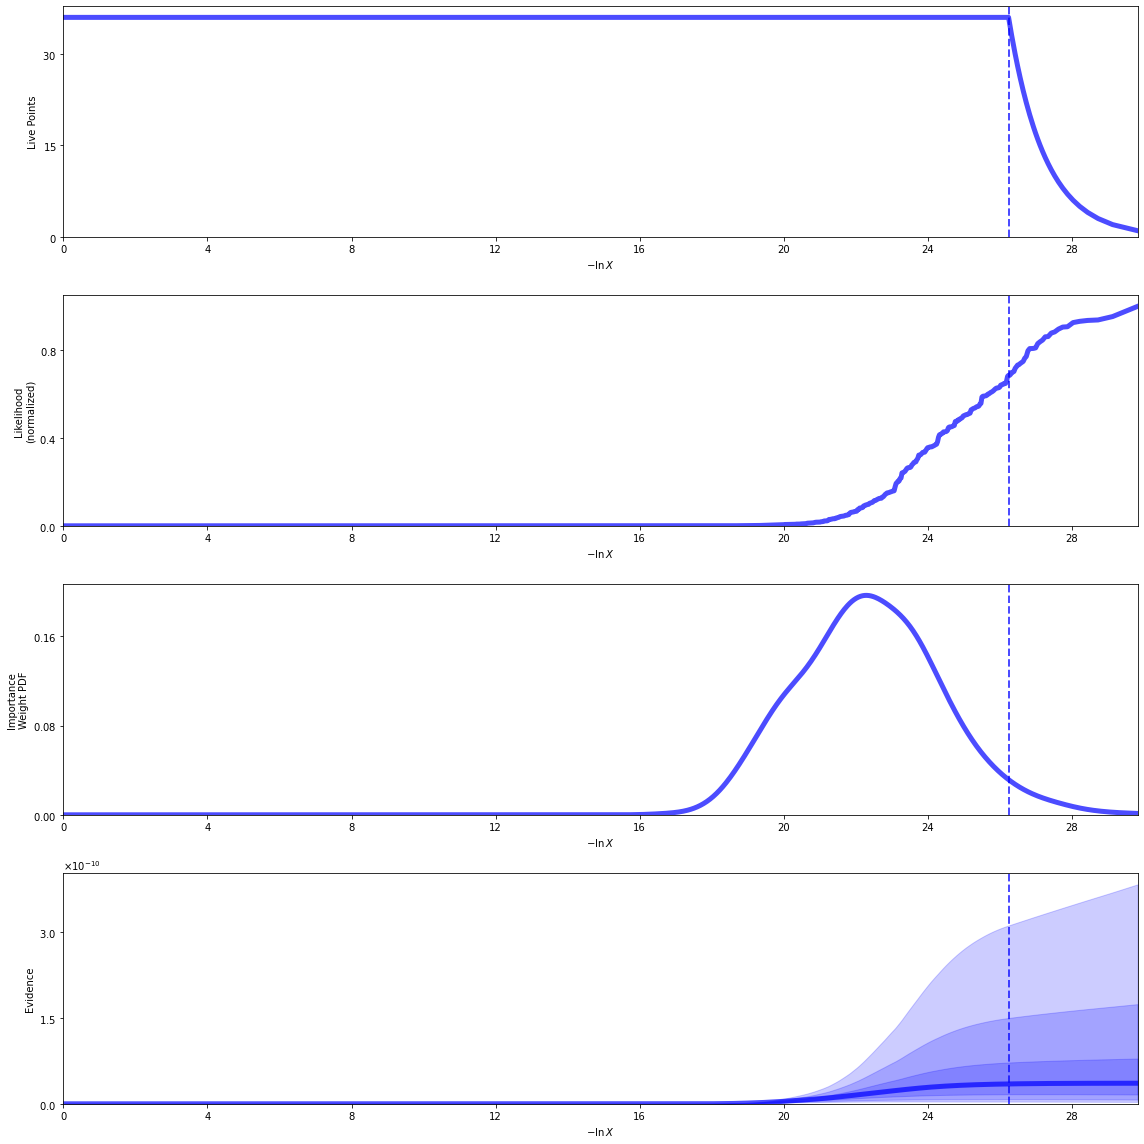

Quantiles:
$x_{1}$ [(0.025, 505.2532946889829), (0.5, 513.2571700124165), (0.975, 523.7915484356733)]
Quantiles:
$x_{2}$ [(0.025, 1413.032522718228), (0.5, 2036.0932950060044), (0.975, 2148.4214026230684)]
Quantiles:
$x_{3}$ [(0.025, 2092.211030085203), (0.5, 2200.2649938827053), (0.975, 2221.277740296263)]
Quantiles:
$x_{4}$ [(0.025, 2210.3661566199876), (0.5, 2884.4290633817295), (0.975, 2988.540256401383)]
Quantiles:
$x_{5}$ [(0.025, 2993.8796511785813), (0.5, 3033.560806145999), (0.975, 3085.5757326370112)]
Quantiles:
$x_{6}$ [(0.025, 3111.9463343013845), (0.5, 3159.508705681005), (0.975, 3845.3149418554162)]
Quantiles:
$y_{1}$ [(0.025, 70.20377567191093), (0.5, 90.78879516604114), (0.975, 104.48700507389927)]
Quantiles:
$y_{2}$ [(0.025, 435.91969319783163), (0.5, 1420.9935313358344), (0.975, 3189.1710821642264)]
Quantiles:
$y_{3}$ [(0.025, 55.98331874910537), (0.5, 96.5821897049064), (0.975, 1054.2363179743375)]
Quantiles:
$y_{4}$ [(0.025, 23.86824959395754), (0.5, 81.555134319740

In [33]:
from lib import util

util.dyplot(results, context['dimlabels'], cornerplot=False)

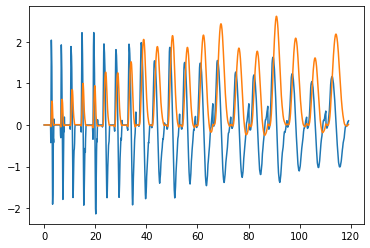

In [16]:
# Load an example DGF to convolve h(t) with
t, u = np.load("vtr/prior/dgf.npy")
plot(t, u)
plot(t, cumsum(u)*(t[1]-t[0]))

Num formants: 3
F vs F_true: [ 508. 2194. 3108.] [ 514.29 2203.28 3044.58]
B vs B_true: [ 47.6   44.4  225.49] [47.04 41.86 91.82]
Errors: 20.320785248192053 79.4837560917164 4.683877359026802
mu2(analytical) [msec] = 0.8379076301161961


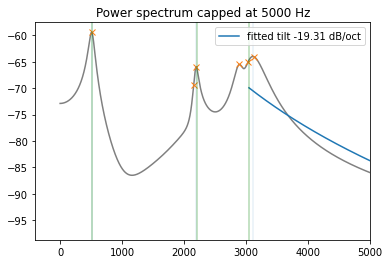

In [36]:
from IPython.display import Audio

def sample_posterior(results):
    return util.resample_equal(results, 1).squeeze()

def analyze(sample, context, w=None):
    x, y = context['unpack'](sample)
    
    vtfilter = context['vtfilter']
    if w is None:
        w = vtfilter.randw()

    f = context['f']
    power = vtfilter.transfer_function_power_dB(
        f, x, y, w
    )

    # Heuristically measure formants
    F, B = spectrum.get_formants_from_spectrum(f, power)

    # Heuristically measure spectral tilt starting from F3(true)
    cutoff = context['F_true'][-1]
    tilt, interp_tilt = spectrum.fit_tilt(f, power, cutoff=cutoff, return_interp=True)
    
    # Calculate impulse response energy (in msec)
    energy = vtfilter.impulse_response_energy(x, y, w)
    
    print("Num formants:", len(F))
    if len(F) == 3:
        F_err = np.sum(((F - context['F_true'])/context['sigma_F'])**2)
        B_err = np.sum(((B - context['B_true'])/context['sigma_B'])**2)
        print("F vs F_true:", np.round(F, 2), np.round(context['F_true'], 2))
        print("B vs B_true:", np.round(B, 2), np.round(context['B_true'], 2))
    else:
        F_err = inf
        B_err = inf
    
    tilt_err = ((tilt - context['tilt_target'])/context['sigma_tilt'])**2
    print("Errors:", F_err, B_err, tilt_err)
    print("mu2(analytical) [msec] =", energy)
    
    # Plot stuff
    power = vtfilter.transfer_function_power_dB(f, x, y, w)
    plot(f, power, "grey")
    plot(f[f>cutoff], interp_tilt(f[f>cutoff]), label=f"fitted tilt {round(tilt,2)} dB/oct")
    plot(x, np.interp(x, f, power), 'x')
    for Fi in F: axvline(Fi, alpha=.1)
    for Fi in context['F_true']: axvline(Fi, alpha=.3, color="green")
    xlim(None, 5000);
    title("Power spectrum capped at 5000 Hz")
    legend()
    show()
    
    t, dt = np.linspace(0., 50, int(50*constants.FS_KHZ), retstep=True) # msec
    h = vtfilter.impulse_response(t, x, y, w)
    plot(t, h, label="$h(t)$")
    d = convolve(h, u)*dt
    plot(d, label="$d(t) = u(t) * h(t)$")
    title("Example convolution in the time domain")
    legend()
    show()
    
    magnitude_spectrum(d, Fs=constants.FS_HZ, scale='dB')
    title("Power spectrum of $d(t)$ in the previous plot")
    show()
    
    display(Audio(d, rate=constants.FS_HZ, autoplay=True))
    
    return x, y

x, y = analyze(sample_posterior(results), context)

## Aggregate

In [135]:
def get_TFB_row(fit):
    row = np.concatenate((
        [fit['sample']['T']],
        fit['sample']['F'],
        fit['sample']['B']
    ))
    return row

def posterior_of_fitted_TFB_values(K, numsamples=50):
    def process():
        for fit in polezero.get_fitted_TFB_samples():
            if fit['K'] == K:
                row = get_TFB_row(fit)
                rows = np.repeat(row[None,:], numsamples, axis=0)
                samples = util.resample_equal(fit['results'], numsamples)
                yield np.column_stack((rows, samples))

    return np.vstack(list(process()))

In [220]:
Kpost = 8

vtfilter = polezero.PoleZeroFilter(Kpost)

def randz(size=None):
    ndim = 7 + 2*Kpost
    return randn(ndim) if size is None else randn(size,ndim)

post_samples = np.vstack(posterior_of_fitted_TFB_values(Kpost))

[Memory]11951.4s, 199.2min: Loading get_TFB_samples...
________________________________________________________________________________
[Memory] Calling vtr.prior.bandwidth.run_nested...
run_nested(34454999, {'bootstrap': 10, 'nlive': 18, 'sample': 'rslice'}, {'maxcall': 10000000, 'save_bounds': False})


9it [00:02,  3.41it/s, bound: 2 | nc: 55 | ncall: 465 | eff(%):  1.935 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.027]Traceback (most recent call last):
  File "/home/marnix/thesis/py/venv/lib/python3.10/site-packages/dynesty/dynesty.py", line 1027, in __call__
    return self.func(x.copy(), *self.args, **self.kwargs)
  File "/home/marnix/thesis/py/vtr/prior/bandwidth.py", line 250, in loglike_montecarlo
    powers = vtfilter.transfer_function_power_dB(f, x, y, ws)
  File "/home/marnix/thesis/py/vtr/prior/polezero.py", line 136, in transfer_function_power_dB
    H = np.sum(terms, axis=-2)
  File "<__array_function__ internals>", line 180, in sum
  File "/home/marnix/thesis/py/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py", line 2296, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/home/marnix/thesis/py/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py", line 86, in _wrapred

Exception while calling loglikelihood function:
  params: [ 582.98669031  949.69345042 1183.2686295    51.67287197 2002.96314578
  102.7434743 ]
  args: [array([[ 0.41462729,  0.52025017, -2.08345867, -0.90418689,  1.02110814,
        -0.23068917]])]
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
import corner

fig = corner.corner(
    post_samples,
    labels=(*bandwidth.TFB_NAMES, *["x"]*Kpost, *["y"]*Kpost),
    show_titles=True,
    smooth=1.
);

In [214]:
from dgf import bijectors

post_bounds = np.array([
    [(100., 5000.)]*Kpost + [(20., 5000.)]*Kpost,
]).squeeze()

post_bounds = np.vstack((bandwidth.TFB_BOUNDS, post_bounds))

samplerargs = {'nlive': Kpost} # Very little but we only care about ML point

b, bresults = bijectors.fit_nonlinear_coloring_bijector(
    post_samples, post_bounds, 12345678900000000010000,
    samplerargs=samplerargs, return_fit_results=True
)

________________________________________________________________________________
[Memory] Calling dgf.bijectors.run_nested...
run_nested(12345678900000000010000, {'nlive': 8}, {'save_bounds': False})


/home/marnix/thesis/py/venv/lib/python3.10/site-packages/dynesty/dynesty.py:515: UserWarning: Beware! Having `nlive <= 2 * ndim` is extremely risky!
  warnings.warn("Beware! Having `nlive <= 2 * ndim` is extremely risky!")
404it [10:47,  1.60s/it, +8 | bound: 129 | nc: 1 | ncall: 52968 | eff(%):  0.778 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  2.181 | dlogz:  0.002 >  0.017]

____________________________________________________run_nested - 653.6s, 10.9min


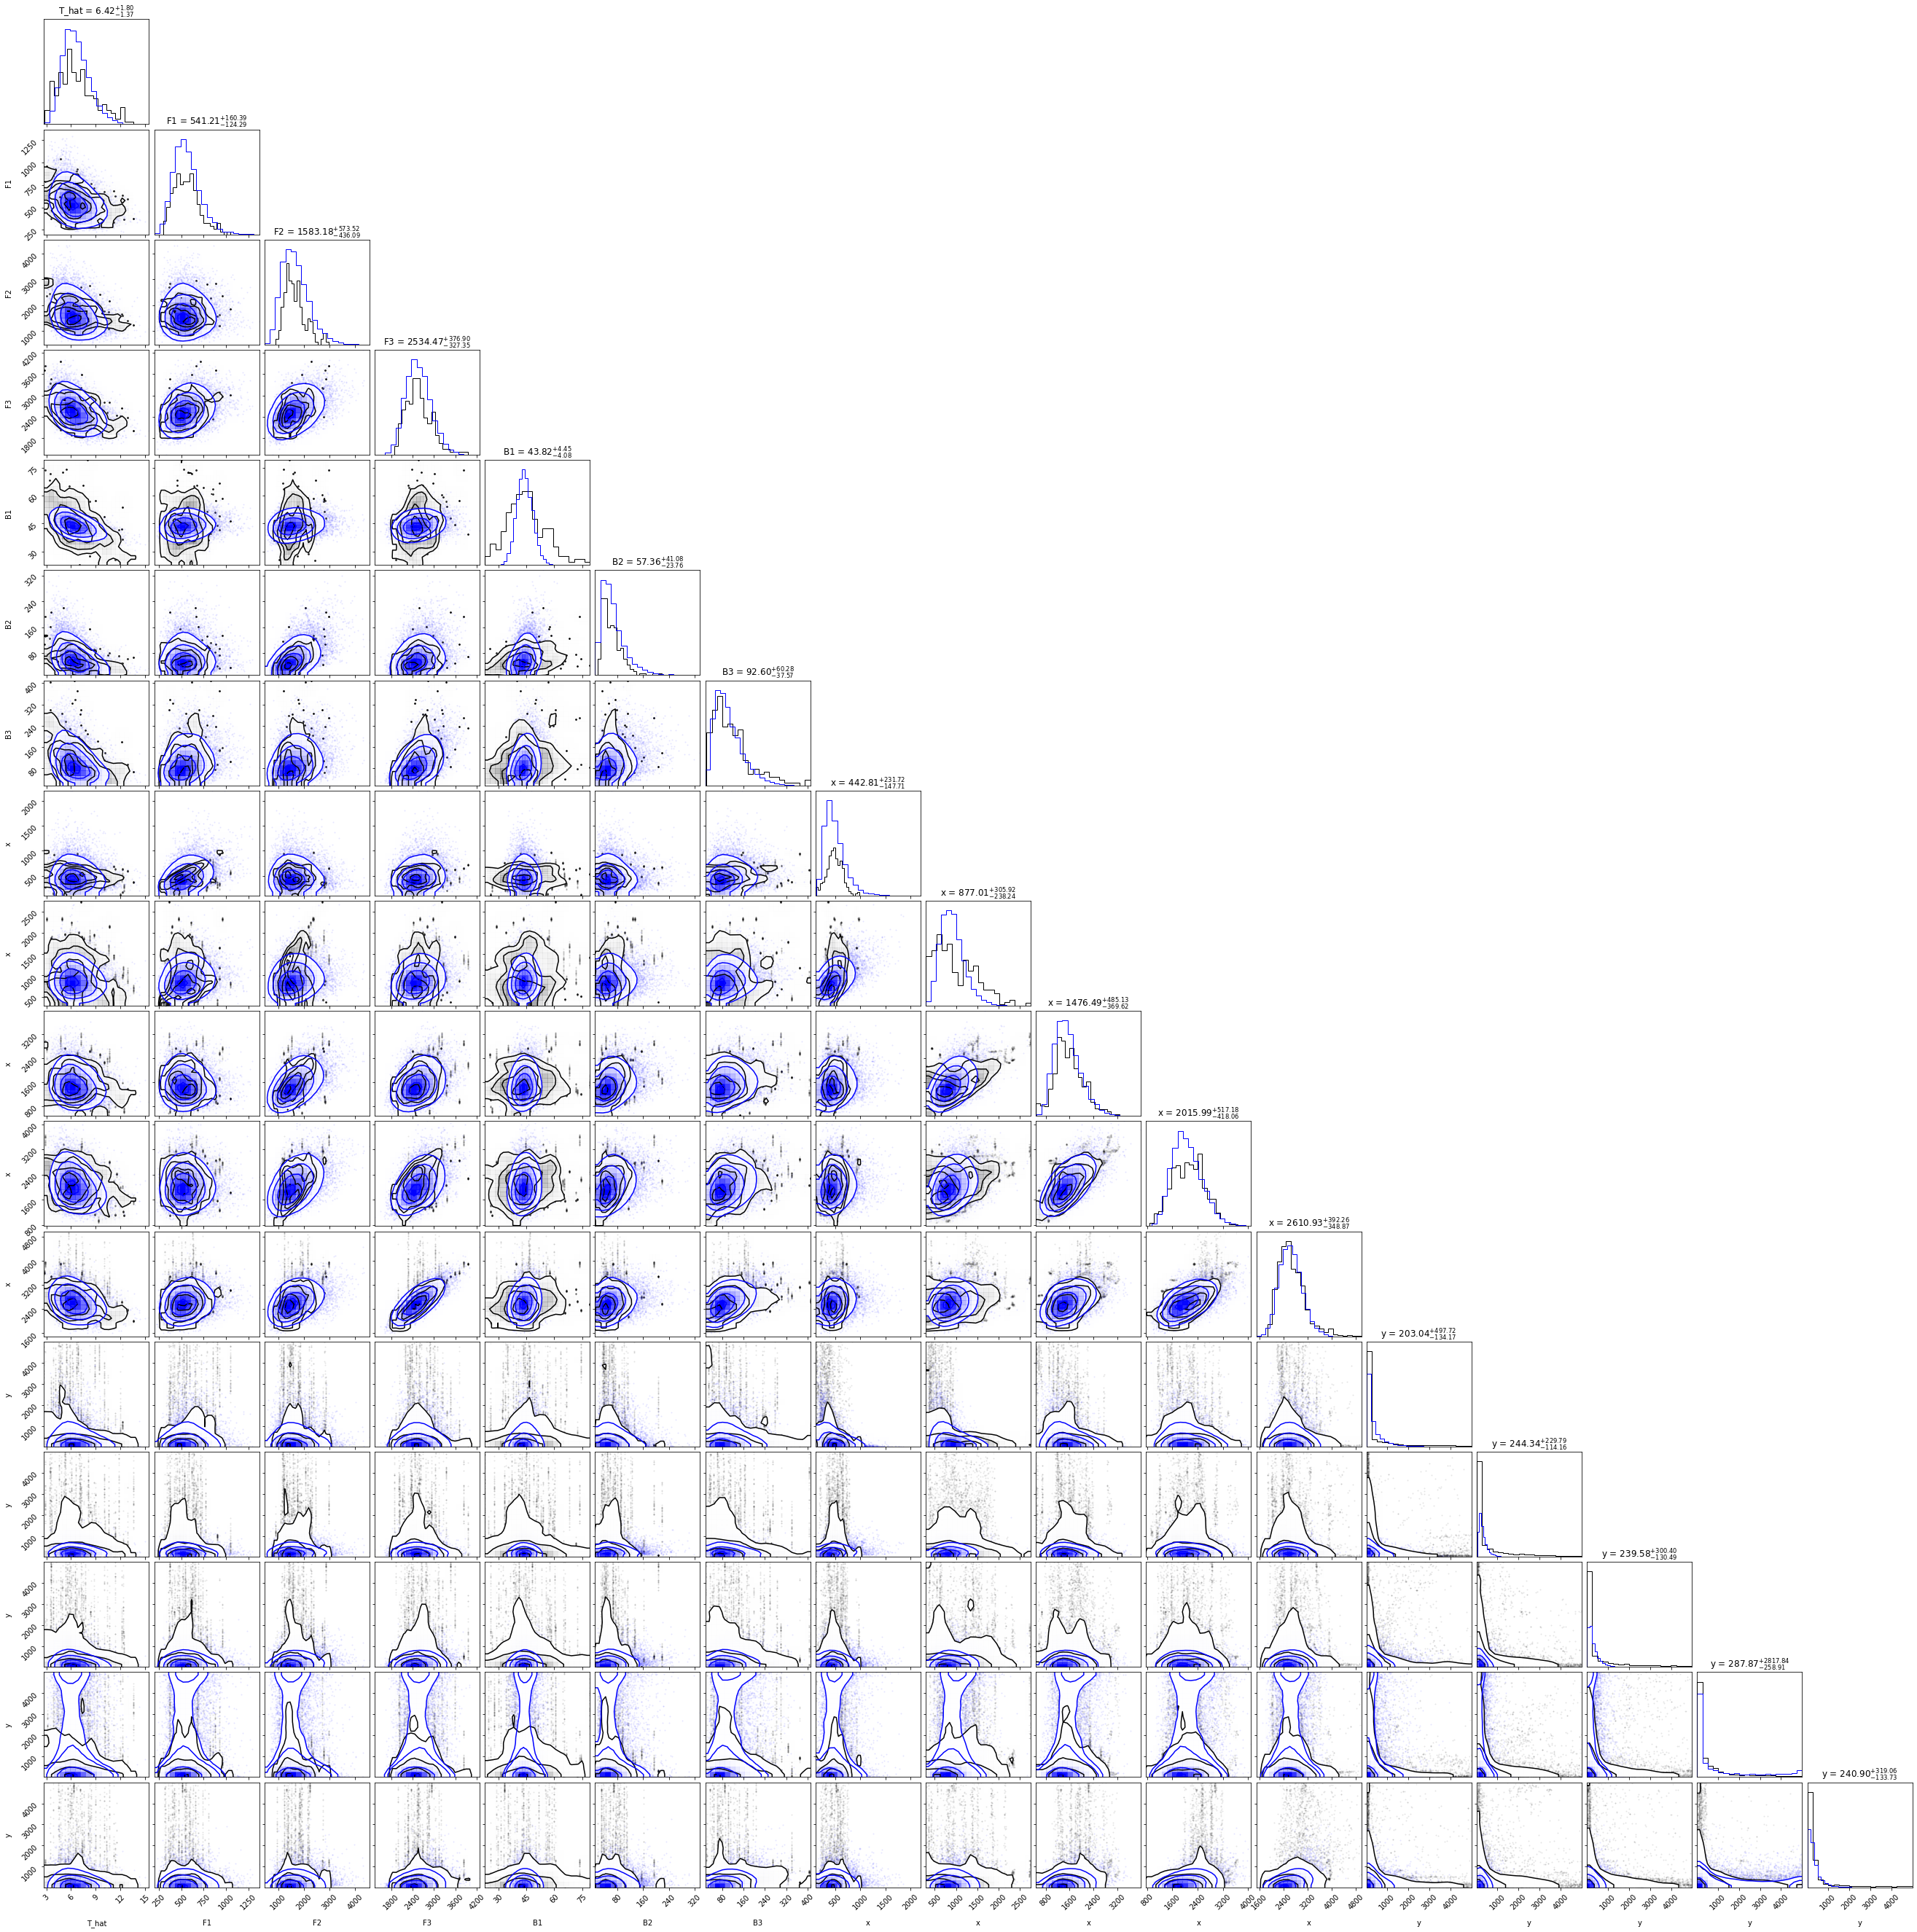

In [207]:
corner.corner(
    array(b.forward(randn(10000, 7 + 2*Kpost))),
    labels=(*bandwidth.TFB_NAMES, *["x"]*Kpost, *["y"]*Kpost),
    show_titles=True,
    smooth=1.,
    fig=fig,
    color="blue"
)

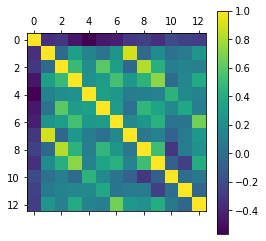

In [117]:
matshow(bijectors.get_log_stats(post_samples, post_bounds)['corr'])
colorbar();

Now we can check the spillover of the impulse response in adjacent pitch pitch periods. This is substantial and confirms our earlier conclusion (in the detrending paper) that no-spillover effects only work for roughly $F_0 < 120$ Hz, i.e., typically male speakers.

F0 = 180.34397382303055 Hz
[   5.54495933  641.52343902 1538.7928547  2452.07058536   43.64510822
   91.22045472  152.83514529]
[ 352.4421345   477.02878471 1111.65755571 1976.36988039 2841.16864517] [1991.17440598   77.78744898  375.09678276   20.93750824  630.73850239]


F0 = 145.73304760065832 Hz
[   6.86186158  314.54754618 1560.44350166 2125.99687378   45.22698485
   52.1110343    39.09944912]
[ 311.87330409  981.42170468 1791.56625222 1666.6841251  2063.2018055 ] [ 41.73011181 672.45697259 620.8850329  221.26009995  93.90328603]


F0 = 166.2308178167712 Hz
[   6.0157317   624.88610551 2635.38868135 2814.98085857   46.60671522
   86.74675483  167.48039102]
[ 622.35500928  964.51661568 2323.31168978 2253.3722884  3333.88812316] [ 153.29464104  141.4724423  1525.31994581 4913.98182207  303.98450555]


F0 = 147.62877009800633 Hz
[   6.77374742  498.13465026 1337.04573015 2247.69939763   42.13007733
   49.19796228   86.00587261]
[ 244.41558355  811.60270122 1171.4903016  1503.57174655 2284.811358  ] [828.55417871 364.07433882 129.46877605 105.81147717  89.25898887]


F0 = 123.47402406027086 Hz
[   8.09886944  825.87220698 1324.01784285 2115.45825493   43.36748897
   23.27433215   73.02949017]
[ 489.5466141   884.43199476 1022.42246751 1502.45915556 2293.61381257] [519.83383644 295.58507086 322.27664562  20.88233457 510.76883679]


F0 = 202.8275445816204 Hz
[   4.93029683  582.42193952 1418.24871679 2699.20179181   43.97035237
   60.79310847  157.08911524]
[ 838.69263005 1170.99076639 1830.60479596 2538.49967171 3574.91761197] [ 174.14409301  427.99706462   66.1294429  1031.27561284 1590.59466526]


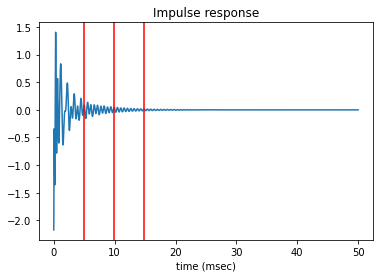

F0 = 154.13387270478898 Hz
[   6.48786657  463.21057616 1571.46976265 2143.13964721   45.35713651
   79.99198347  104.0405234 ]
[ 220.19866699  530.84366868 1011.42375701 1902.90650709 2286.16210655] [990.48035375 331.95769936  66.77188648  52.68524117 272.20675265]


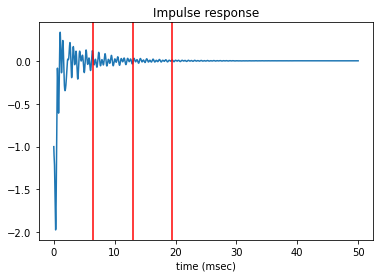

F0 = 223.1934516400833 Hz
[   4.48041819  877.0422555  2380.67290362 2896.10433935   53.330335
  117.30945118  106.82713968]
[ 433.51066326  752.22984422 1715.69987012 1939.51983498 2566.25315384] [1133.59021337  111.88041613  766.45416587 3566.03508569  102.40042653]


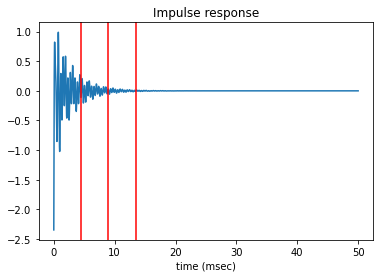

F0 = 115.29352764606125 Hz
[   8.67351377  480.40164845 1197.72264976 2387.83625488   39.92070454
   47.07041218   56.42097725]
[ 719.92648797 1079.07494154 1332.41555892 1976.58923179 2456.52893663] [  65.33328541  214.69799192  136.54919949 4111.76845964  154.74148234]


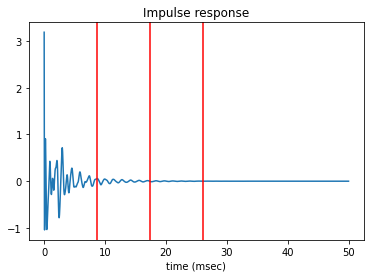

F0 = 94.81042426801423 Hz
[  10.54736341  361.29105817 1339.16390007 2355.76653167   35.85784565
   30.29478939   59.69670169]
[ 510.3414987   630.9130979  1650.45347057 2767.7944566  2497.52036121] [105.39898274 309.12665158 106.59417291 128.11590355 260.89555753]


In [210]:
def unpack_sample(s):
    TFB = sample[:7]
    xy = sample[7:]
    return TFB, xy

for i in range(10):
    sample = b.forward(randz())
    TFB, xy = unpack_sample(sample)
    T = TFB[0]
    print("F0 =", 1000/T, "Hz")
    print(TFB)
    x, y = np.split(xy, 2)
    print(x, y)
    
    t, dt = linspace(0, 50, 100000, retstep=True) # msec
    h = vtfilter.impulse_response(t, x, y, vtfilter.randw())
    plot(t, h)
    title("Impulse response")
    xlabel("time (msec)")
    axvline(T, color="red")
    axvline(2*T, color="red")
    axvline(3*T, color="red")
    show()

# peaks, tilt = 2 -2.367067691326154
F = [ 386.9 1796.4 2339.5] [ 516. 2105.]
B = [ 35.6  49.1 101.3] [107. 377.]


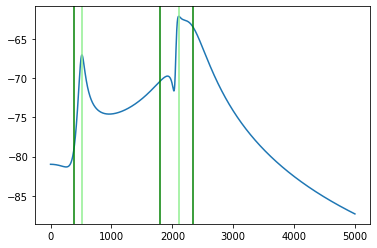

In [132]:
def unpack_TFB(TFB):
    T, F, B = np.split(TFB, [1, 4])
    return T, F, B

for i in range(1):
    sample = b.forward(randz())
    TFB, xy = unpack_sample(sample)
    _, F_true, B_true = unpack_TFB(TFB)
    x, y = np.split(xy, 2)

    f = constants.spectrum_frequencies()
    power = vtfilter.transfer_function_power_dB(f, x, y, vtfilter.randw())

    plot(f, power + i*30, label="our implementation")
    
    nopeaks = spectrum.number_of_peaks(f, power)
    F, B = spectrum.get_formants_from_spectrum(f, power)
    
    print("# peaks, tilt =", nopeaks, spectrum.fit_tilt(f, power))
    print("F =", np.round(F_true, 1), F)
    print("B =", np.round(B_true, 1), np.round(B))
    for Fi in F_true: axvline(Fi, color="green")
    for Fi in F: axvline(Fi, color="lightgreen")

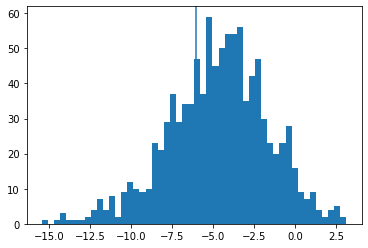

In [134]:
nopeaks = []
tilts = []

f = constants.spectrum_frequencies()

for i in range(1000):
    sample = b.forward(randz())
    TFB, xy = unpack_sample(sample)
    x, y = np.split(xy, 2)

    power = vtfilter.transfer_function_power_dB(f, x, y, vtfilter.randw())

    nopeaks += [spectrum.number_of_peaks(f, power)]
    tilts += [spectrum.fit_tilt(f, power)]

hist(nopeaks, bins=50);
show()
hist(tilts, bins=50);
axvline(vtfilter.analytical_tilt())

## Quantify information

We calculate the KL divergence between the MVNs in the (softclipped) log domain, but note that this does not matter, since it is invariant under transformations.

The higher the KL divergence from $p(F^R, B^R)$ (which is implicit in the `TFB` prior) to $p(F,B)$, the *less* $K$ is to be weighted.
Here $p(F,B)$ is defined by heuristically measuring $F$ and $B$ from samples $x, y \sim p(x,y,T,F^R,B^R)$. We do not:
- Use $\log Z$ values summed over all samples for a given $K$ to determine goodness of fit, since we use very cheap pseudo-MCMC and deriving $\exp(\log Z)$ weights from this is impossible (this is importance sampling in large dimensions -- so huge weight differences)
- Quantify the correlation between $(F,B|F^R,B^R)$ and $(F^R,B^R)$; we only look at the global picture. In general this correlation is only strong for $K = 3$ and perhaps $K = 4$ anyway (at least for PZ). It is interesting to know how well the PZ prior actually conforms to the given $F^R, B^R$ values, but the KL divergence does not measure that.

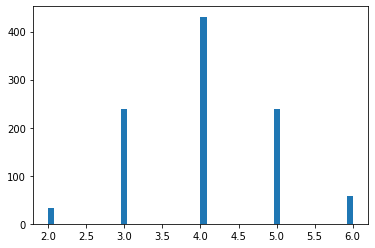

Penalty [ban] for requiring $N_F = 3$ = 0.6216020990518623


In [215]:
nopeaks = []
tilts = []
FBs = []

nsamp = 1000

f = constants.spectrum_frequencies()
samples = b.forward(randz(nsamp))

for i in range(nsamp):
    sample = samples[i,:]
    TFB, xy = unpack_sample(sample)
    T, F_ref, B_ref = unpack_TFB(TFB)
    x, y = np.split(xy, 2)

    power = vtfilter.transfer_function_power_dB(f, x, y, vtfilter.randw())
    
    F, B = spectrum.get_formants_from_spectrum(f, power)
    nopeak = len(F)
    
    nopeaks += [nopeak]
    if nopeak == 3:
        FBs += [np.concatenate((F, B))]

hist(nopeaks, bins=50);
show()

proportion = (np.sum(np.array(nopeaks) == 3))/len(nopeaks)
print("Penalty [ban] for requiring $N_F = 3$ =", np.log10(1/proportion))

In [216]:
# K = 3
from lib import util

FB_bounds = bandwidth.TFB_BOUNDS[1:,:]

def fit_mvn_in_log_domain(FB):
    stats = bijectors.get_log_stats(FB, FB_bounds)
    return stats['mean'], stats['cov']

FB_xy = np.vstack(FBs)
FB_ref = bandwidth.sample_TFB()[:,1:]

kl_div = util.kl_mvn(
    fit_mvn_in_log_domain(FB_ref),
    fit_mvn_in_log_domain(FB_xy)
)

util.nats_to_ban(kl_div) - np.log10(proportion)

[Memory]11784.6s, 196.4min: Loading get_vtrformants_training_data...
[Memory]11786.4s, 196.4min: Loading run_nested...


4.032496383479482

NEED TO WEIGH INVERSELY! So 1/KL_ban because the smaller this banz, the better the model.

It works well and has moderate effect on weighing, so good. Now we can compare AP and PZ models (directly using ban values) and aggregate over $K$ values by using the inverse weights.

We can use the same technique for the source model.

Other interesting statistics would be energy decay per pitch period as a function of $F_0$. To show that we need to take into account spillover effects. And that this is crucial to support pitch-synchronous analysis for female and children voices.